# Untersuchung der Datensätze

In [19]:
import os
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import dask.dataframe as dd
from dask.distributed import Client

In [20]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='20_investigation.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017'
verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018'

# Dask Client starten
client = Client()  # Dask Client starten
client

/home/michi/BA/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40033 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40033/status,
Dashboard: http://127.0.0.1:40033/status,Workers: 7
Total threads: 28,Total memory: 54.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38791,Workers: 7
Dashboard: http://127.0.0.1:40033/status,Total threads: 28
Started: Just now,Total memory: 54.92 GiB
Comm: tcp://127.0.0.1:40497,Total threads: 4
Dashboard: http://127.0.0.1:33953/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:40021,


## Entpacken der Datensätze

In [3]:
# ids17
!rm -r ../01_Datensaetze/improved_cic-ids-2017/*.csv
!unzip -o ../01_Datensaetze/improved_cic-ids-2017/CICIDS2017_improved.zip -d ../01_Datensaetze/improved_cic-ids-2017/

Archive:  ../01_Datensaetze/improved_cic-ids-2017/CICIDS2017_improved.zip
  inflating: ../01_Datensaetze/improved_cic-ids-2017/friday.csv  
  inflating: ../01_Datensaetze/improved_cic-ids-2017/monday.csv  
  inflating: ../01_Datensaetze/improved_cic-ids-2017/thursday.csv  
  inflating: ../01_Datensaetze/improved_cic-ids-2017/tuesday.csv  
  inflating: ../01_Datensaetze/improved_cic-ids-2017/wednesday.csv  


In [8]:
# ids18
!rm -r ../01_Datensaetze/improved_cse-cic-ids-2018/*.csv
!unzip -o ../01_Datensaetze/improved_cse-cic-ids-2018/CSECICIDS2018_improved.zip -d ../01_Datensaetze/improved_cse-cic-ids-2018/

Archive:  ../01_Datensaetze/improved_cse-cic-ids-2018/CSECICIDS2018_improved.zip
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-14-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Friday-16-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Tuesday-20-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-21-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-22-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Friday-23-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-28-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-01-03-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-15-02-2018.csv  
  inflating: ../01_Datensaetze/improved_cse-cic-ids-2018/Friday-02-03-2018.csv  


In [ ]:
# Parquet Verzeichnisse leeren
!rm -r ../01_Datensaetze/improved_cic-ids-2017/ids17_parquet/*.parquet
!rm -r ../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet/*.parquet


In [ ]:
# Preparation Stufe 0 leeren
!rm -r ../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_0/*.parquet
!rm -r ../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_0/*.parquet
!rm -r ../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_0/*.parquet

In [ ]:
# Preparation Stufe 1 leeren
!rm -r ../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/*.parquet
!rm -r ../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/*.parquet
!rm -r ../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/*.parquet

## Prüfen der Spaltenanzahl beider Datensätze

In [21]:
def count_columns(file):
    df = pd.read_csv(file, nrows=1)
    return {file:df.shape[1]}

def count_columns_in_directory(directory):
    try:
        logging.info(f"Start counting columns in directory {directory}")
        with mp.Pool(processes=5) as pool:
            result = pool.map(count_columns, [os.path.join(directory, datei) for datei in os.listdir(directory) if datei.endswith('.csv')])

        logging.info(f"Successfully counted columns in directory {directory}")
        return result
    except Exception as e:
        logging.error(f"Error counting columns in directory {directory}: {e}")
        return []

In [22]:
count_columns_in_directory(verzeichnis_ids17)

2024-11-16 18:15:38 - INFO - Start counting columns in directory ../01_Datensaetze/improved_cic-ids-2017
2024-11-16 18:15:38 - INFO - Successfully counted columns in directory ../01_Datensaetze/improved_cic-ids-2017


[{'../01_Datensaetze/improved_cic-ids-2017/tuesday.csv': 91},
 {'../01_Datensaetze/improved_cic-ids-2017/wednesday.csv': 91},
 {'../01_Datensaetze/improved_cic-ids-2017/friday.csv': 91},
 {'../01_Datensaetze/improved_cic-ids-2017/monday.csv': 91},
 {'../01_Datensaetze/improved_cic-ids-2017/thursday.csv': 91}]

In [23]:
count_columns_in_directory(verzeichnis_ids18)

2024-11-16 18:15:40 - INFO - Start counting columns in directory ../01_Datensaetze/improved_cse-cic-ids-2018
2024-11-16 18:15:40 - INFO - Successfully counted columns in directory ../01_Datensaetze/improved_cse-cic-ids-2018


[{'../01_Datensaetze/improved_cse-cic-ids-2018/Tuesday-20-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-15-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-01-03-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Thursday-22-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-21-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-14-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Friday-23-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Friday-16-02-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Friday-02-03-2018.csv': 91},
 {'../01_Datensaetze/improved_cse-cic-ids-2018/Wednesday-28-02-2018.csv': 91}]

Im Gegensatz zu den originalen Datensätzen ist hier die Spaltenanzahl in beiden Datensätzen gleich.

## Prüfen der Spaltenbezeichnungen beider Datensätze

In [24]:
# ids17
ids17_col_hash = []
for datei in os.listdir(verzeichnis_ids17):
    if datei.endswith('.csv'):
        pfad_zur_datei = os.path.join(verzeichnis_ids17, datei)
        df = pd.read_csv(pfad_zur_datei, nrows=2, skipinitialspace=True)
        ids17_col_hash.append(hash(tuple(df.columns)))

# Prüfen, ob alle Elemente in der Liste gleich sind
all_equal = all(x == ids17_col_hash[0] for x in ids17_col_hash)

if all_equal:
    print(f'Die Spaltennamen in allen ids17-CSVs sind gleich.') 
    ids17_columns = df.columns 
else:
    print(f'Die Spaltennamen in den ids17-CSVs sind unterschiedlich.')

del df

Die Spaltennamen in allen ids17-CSVs sind gleich.


In [25]:
ids18_col_hash = []
for datei in os.listdir(verzeichnis_ids18):
    if datei.endswith('.csv'):
        pfad_zur_datei = os.path.join(verzeichnis_ids18, datei)
        df = pd.read_csv(pfad_zur_datei, nrows=2)
        ids18_col_hash.append(hash(tuple(df.columns)))

# Prüfen, ob alle Elemente in der Liste gleich sind
all_equal = all(x == ids17_col_hash[0] for x in ids17_col_hash)

if all_equal:
    print(f'Die Spaltennamen in allen ids18-CSVs sind gleich.') 
    ids18_columns = df.columns 
else:
    print(f'Die Spaltennamen in den ids18-CSVs sind unterschiedlich.')

del df

Die Spaltennamen in allen ids18-CSVs sind gleich.


Bei Ungleichheit genaue Spaltennamen vergleichen:

In [26]:
# Element für Element Vergleich
for col17, col18 in zip(ids17_columns, ids18_columns):
    if col17 == col18:
        print(f"Die Spalten sind gleich:".ljust(40), f'{col17}')
    else:
        print(f"Die Spalten sind unterschiedlich:".ljust(40), f"{col17} != {col18}")

Die Spalten sind gleich:                 id
Die Spalten sind gleich:                 Flow ID
Die Spalten sind gleich:                 Src IP
Die Spalten sind gleich:                 Src Port
Die Spalten sind gleich:                 Dst IP
Die Spalten sind gleich:                 Dst Port
Die Spalten sind gleich:                 Protocol
Die Spalten sind gleich:                 Timestamp
Die Spalten sind gleich:                 Flow Duration
Die Spalten sind gleich:                 Total Fwd Packet
Die Spalten sind gleich:                 Total Bwd packets
Die Spalten sind gleich:                 Total Length of Fwd Packet
Die Spalten sind gleich:                 Total Length of Bwd Packet
Die Spalten sind gleich:                 Fwd Packet Length Max
Die Spalten sind gleich:                 Fwd Packet Length Min
Die Spalten sind gleich:                 Fwd Packet Length Mean
Die Spalten sind gleich:                 Fwd Packet Length Std
Die Spalten sind gleich:                 Bwd Pack

Da sich die Bezeichnung der Spalten zwischen ids17 und ids18 nicht wie in den originalen Datensätzen unterscheidet muss für die verbesserten Datensätze hier keine Anpassung erfolgen.

## CSV Dateien in dask.dataframe laden

In [ ]:
def load_csvs_to_dask_dataframe(directory):
    try:
        logging.info(f"Lade alle CSV-Dateien aus dem Verzeichnis {directory} in ein Dask DataFrame")
        ddf = dd.read_csv(os.path.join(directory, '*.csv'), assume_missing=True, blocksize='64MB')
        logging.info(f"Dask DataFrame erfolgreich erstellt.")
        return ddf
    except Exception as e:
        logging.error(f"Fehler beim Laden der CSV-Dateien aus dem Verzeichnis {directory}: {e}")
        return None
    
def get_shape(df):
    n_rows = df.shape[0].compute()
    n_cols = len(df.columns)
    return n_rows, n_cols

In [28]:
ddf_ids17 = load_csvs_to_dask_dataframe(verzeichnis_ids17)

2024-11-16 18:16:09 - INFO - Lade alle CSV-Dateien aus dem Verzeichnis ../01_Datensaetze/improved_cic-ids-2017 in ein Dask DataFrame
2024-11-16 18:16:09 - INFO - Dask DataFrame erfolgreich erstellt.


In [29]:
ddf_ids18 = load_csvs_to_dask_dataframe(verzeichnis_ids18)

2024-11-16 18:16:10 - INFO - Lade alle CSV-Dateien aus dem Verzeichnis ../01_Datensaetze/improved_cse-cic-ids-2018 in ein Dask DataFrame
2024-11-16 18:16:10 - INFO - Dask DataFrame erfolgreich erstellt.


In [30]:
print(get_shape(ddf_ids17))
print(get_shape(ddf_ids18))

(2099976, 91)
(63195145, 91)


## Auf NaN und Inf Werte prüfen

In [14]:
def check_nan_and_inf_in_dask_dataframe(df):
    # Prüfen auf NaN-Werte
    nan_count = df.isna().sum().compute()
    logging.info("NaN values in each column:")
    logging.info(nan_count)

    # Prüfen auf Inf-Werte (sowohl positive als auch negative)
    inf_count = ((df == np.inf) | (df == -np.inf)).sum().compute()
    logging.info("Inf values in each column:")
    logging.info(inf_count)

In [15]:
logging.info("Prüfe NaN und Inf Werte in ids17")
check_nan_and_inf_in_dask_dataframe(ddf_ids17)

2024-11-16 18:09:34 - INFO - Prüfe NaN und Inf Werte in ids17
2024-11-16 18:09:36 - INFO - NaN values in each column:
2024-11-16 18:09:36 - INFO - id                            0
Flow ID                       0
Src IP                        0
Src Port                      0
Dst IP                        0
Dst Port                      0
Protocol                      0
Timestamp                     0
Flow Duration                 0
Total Fwd Packet              0
Total Bwd packets             0
Total Length of Fwd Packet    0
Total Length of Bwd Packet    0
Fwd Packet Length Max         0
Fwd Packet Length Min         0
Fwd Packet Length Mean        0
Fwd Packet Length Std         0
Bwd Packet Length Max         0
Bwd Packet Length Min         0
Bwd Packet Length Mean        0
Bwd Packet Length Std         0
Flow Bytes/s                  0
Flow Packets/s                0
Flow IAT Mean                 0
Flow IAT Std                  0
Flow IAT Max                  0
Flow IAT Min         

In [16]:
logging.info("Prüfe NaN und Inf Werte in ids18")
check_nan_and_inf_in_dask_dataframe(ddf_ids18)

2024-11-16 18:10:01 - INFO - Prüfe NaN und Inf Werte in ids18
2024-11-16 18:10:50 - INFO - NaN values in each column:
2024-11-16 18:10:50 - INFO - id                            0
Flow ID                       0
Src IP                        0
Src Port                      0
Dst IP                        0
Dst Port                      0
Protocol                      0
Timestamp                     0
Flow Duration                 0
Total Fwd Packet              0
Total Bwd packets             0
Total Length of Fwd Packet    0
Total Length of Bwd Packet    0
Fwd Packet Length Max         0
Fwd Packet Length Min         0
Fwd Packet Length Mean        0
Fwd Packet Length Std         0
Bwd Packet Length Max         0
Bwd Packet Length Min         0
Bwd Packet Length Mean        0
Bwd Packet Length Std         0
Flow Bytes/s                  0
Flow Packets/s                0
Flow IAT Mean                 0
Flow IAT Std                  0
Flow IAT Max                  0
Flow IAT Min         

## Korrelationsmatrix berechnen

/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:

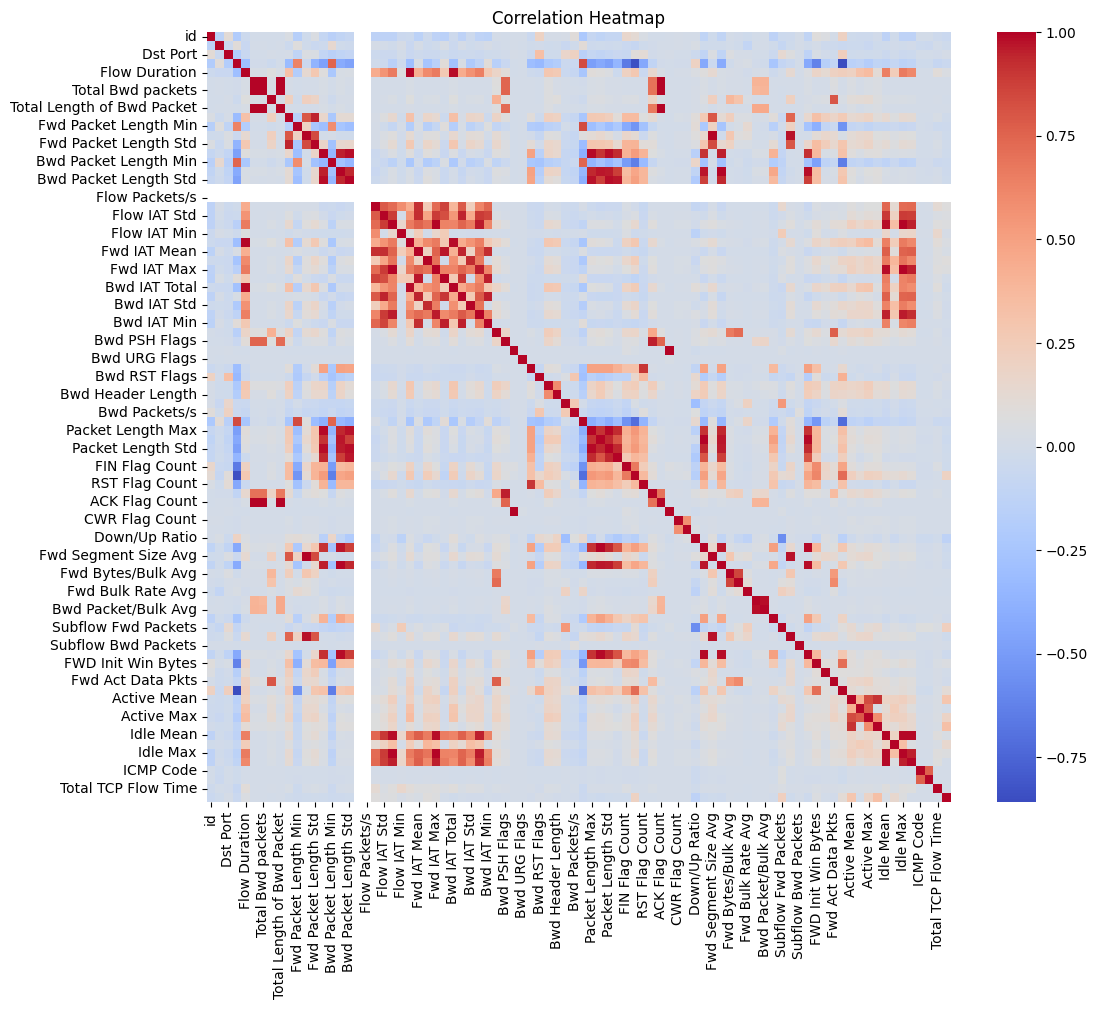

In [40]:
# Berechnung
numeric_ddf_ids17 = ddf_ids17.select_dtypes(include=[np.number])
correlation_matrix_ids17 = numeric_ddf_ids17.corr().compute()
#print(correlation_matrix)

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_ids17, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/michi/BA/.venv/lib/python3.10/site-packages/dask/dataframe/core.py:7509: RuntimeWarning: invalid value encountered in subtract
  np.subtract(df.iloc[:, idx].values[:, None], mu[idx][None, :]) ** 2
/home/michi/BA/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:

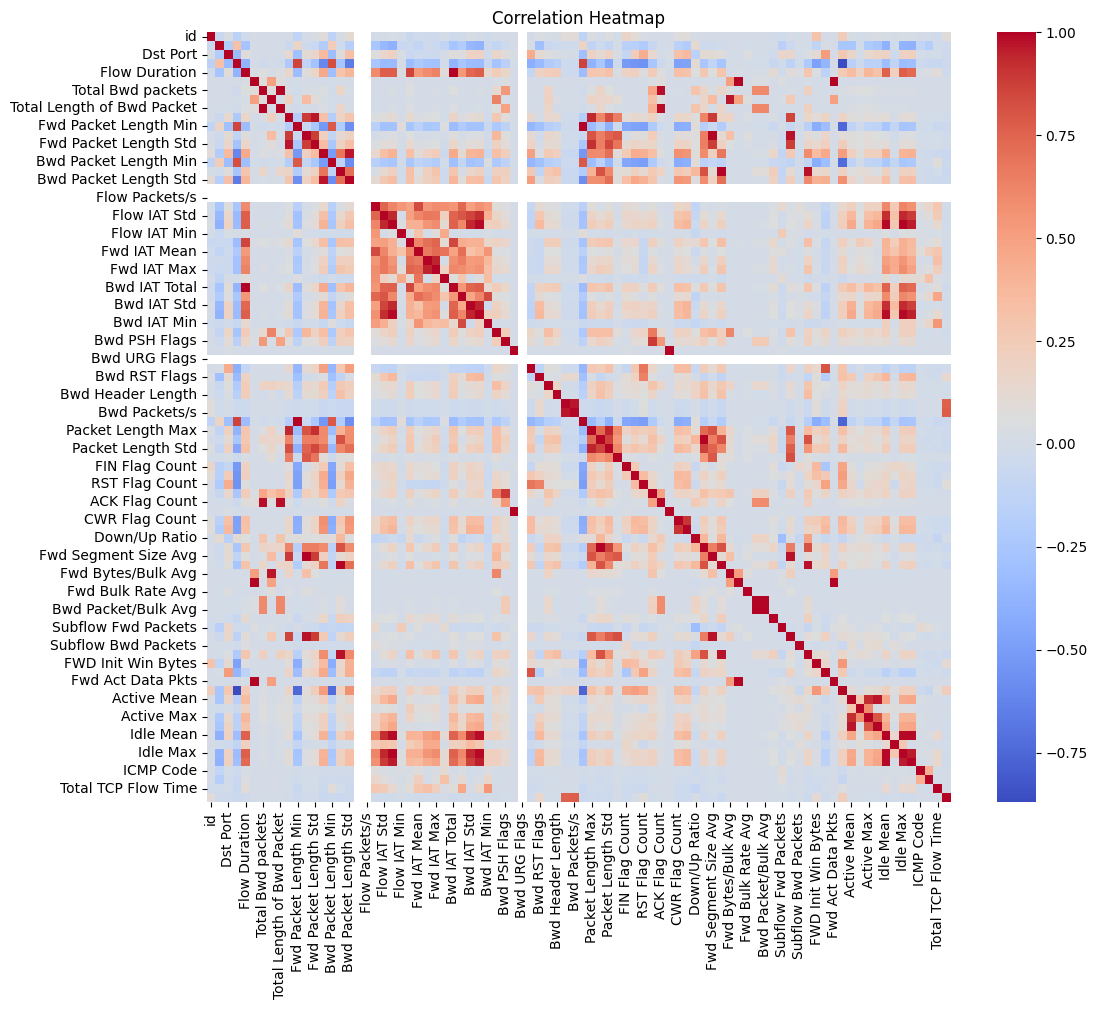

In [ ]:
# Berechnung
numeric_ddf_ids18 = ddf_ids18.select_dtypes(include=[np.number])
correlation_matrix_ids18 = numeric_ddf_ids18.corr().compute()

# Visualisierung
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_ids18, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Speichern der Datensätze als Parquet

In [ ]:
def save_dask_dataframe(df, file_path):
    df.to_parquet(file_path, write_index=False)
    logging.info(f"DataFrame successfully saved to {file_path}")

In [32]:
save_dask_dataframe(ddf_ids17, verzeichnis_ids17 + '/ids17_parquet')

2024-11-16 18:17:31 - INFO - DataFrame successfully saved to ../01_Datensaetze/improved_cic-ids-2017/ids17_parquet


In [33]:
save_dask_dataframe(ddf_ids18, verzeichnis_ids18 + '/ids18_parquet')

2024-11-16 18:19:04 - INFO - DataFrame successfully saved to ../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet


## Dask Client beenden

In [34]:
client.close()